In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 50)

In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import math

# Win expectancy

## IPL games

### Import pre-processed all IPL data

In [4]:
df = pd.read_csv("data/df_kaggleAllIpl_preprocessed.csv")
del df['Unnamed: 0']

In [5]:
df

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN
5,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,6,S Dhawan,DA Warner,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
6,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,7,S Dhawan,DA Warner,TS Mills,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
7,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,1,S Dhawan,DA Warner,A Choudhary,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
8,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,2,DA Warner,S Dhawan,A Choudhary,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
9,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,3,DA Warner,S Dhawan,A Choudhary,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN


In [6]:
len(df)

150460

### Ball by ball win expectancy

### All IPL games

In [7]:
maxRunRateBins = 15
maxBalls = 240
acc = []
numOccurrences  = np.zeros(shape=(maxBalls,maxRunRateBins,11), dtype='int')
numTeamChaseWin = np.zeros(shape=(maxBalls,maxRunRateBins,11), dtype='int')

for m in df['match_id'].unique():
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]
    
    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        ### Count number of instances when team chasing wins the game
        teamChase = dfm[dfm['inning']==2]['batting_team'].unique()[0]
        winner = dfm['winner'].unique()[0]
        teamChaseWin = 1 if (teamChase==winner) else 0

        ball = 0
        firstInningsRuns = 0
        secondInningsRuns = 0
        firstInningsWickets = 0
        secondInningsWickets = 0
        
        for b in range(len(dfm)):  ### For each ball in the match
            
            innings = dfm.iloc[b]['inning']
            
            if dfm.iloc[b]['wide_runs']==0 and dfm.iloc[b]['noball_runs']==0:  ### Do not count wides/no-balls
                ball += 1
              
            if innings==2 and ball==121:    ### Start of second innings
                target = firstInningsRuns+1
                numBallsRemaining = maxBalls/2
                
            if ball!=0 and innings==1:    ### First innings
                firstInningsRuns += dfm.iloc[b]['total_runs']
                #runRate = int(np.around(firstInningsRuns/ball*6, decimals=1)*10)
                #runRate = int(round(firstInningsRuns/ball*6*2)/2*2)
                runRate = int(round(firstInningsRuns/ball*6))
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    firstInningsWickets += 1
                
                if runRate>=maxRunRateBins:
                    runRate=maxRunRateBins-1
                numOccurrences[ball, runRate, firstInningsWickets] += 1
                numTeamChaseWin[ball, runRate, firstInningsWickets] += teamChaseWin
                acc.append(teamChaseWin)
                
            elif innings==2 and numBallsRemaining>1:  ### Second innings   
                numBallsRemaining = maxBalls-ball
                numRunsRemaining = target-secondInningsRuns
                secondInningsRuns += dfm.iloc[b]['total_runs']
                #requiredRunRate = int(np.around(numRunsRemaining/numBallsRemaining*6, decimals=1)*10)
                #requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6*2)/2*2)
                requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6))
                
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    secondInningsWickets += 1
            
                if requiredRunRate >= maxRunRateBins:
                    requiredRunRate = maxRunRateBins-1
                numOccurrences[ball, requiredRunRate, secondInningsWickets] += 1
                numTeamChaseWin[ball, requiredRunRate, secondInningsWickets] += teamChaseWin
                acc.append(teamChaseWin)
            

100
200
300
400
500
600


In [8]:
we = numTeamChaseWin/numOccurrences

In [56]:
maxRunRateBins = 15
maxBalls = 240

we1 = [0] * 240
we1[0] = 0.5
wpa = {}
accRunRate = []
accFirstInningsWickets = []

for m in [2]: #df['match_id'].unique():
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]
    
    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        ### Count number of instances when team chasing wins the game
        teamChase = dfm[dfm['inning']==2]['batting_team'].unique()[0]
        winner = dfm['winner'].unique()[0]
        teamChaseWin = 1 if (teamChase==winner) else 0

        ball = 0
        firstInningsRuns = 0
        secondInningsRuns = 0
        firstInningsWickets = 0
        secondInningsWickets = 0
        
        for b in range(len(dfm)):  ### For each ball in the match
            
            innings = dfm.iloc[b]['inning']
            
            if dfm.iloc[b]['wide_runs']==0 and dfm.iloc[b]['noball_runs']==0:  ### Do not count wides/no-balls
                ball += 1
              
            if innings==2 and ball==121:    ### Start of second innings
                target = firstInningsRuns+1
                numBallsRemaining = maxBalls/2
                
            if ball!=0 and innings==1:    ### First innings
                firstInningsRuns += dfm.iloc[b]['total_runs']
                #runRate = int(np.around(firstInningsRuns/ball*6, decimals=1)*10)
                #runRate = int(round(firstInningsRuns/ball*6*2)/2*2)
                runRate = int(round(firstInningsRuns/ball*6))

                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    firstInningsWickets += 1
                    
                accRunRate.append(runRate)
                accFirstInningsWickets.append(firstInningsWickets)
                
                if runRate>=maxRunRateBins:
                    runRate=maxRunRateBins-1
                    
                #we1[ball] = we[ball, runRate, firstInningsWickets]
                raw = we[:,runRate, firstInningsWickets]
                raw = [0.5 if math.isnan(x) else x for x in raw]
                filtered = lowess(raw, range(len(raw)), is_sorted=True, frac=0.3)
                we1[ball] = filtered[ball,1]
                deltaWe = we1[ball] - we1[ball-1]
                
                if deltaWe<0:
                    batsman = dfm.iloc[b]["batsman"]
                    if batsman in wpa:
                        wpa[batsman] += abs(deltaWe/2)
                    else:
                        wpa[batsman] = abs(deltaWe/2)
                    
                    bowler = dfm.iloc[b]["bowler"]
                    if bowler in wpa:
                        wpa[bowler] -= abs(deltaWe/2)
                    else:
                        wpa[bowler] = -abs(deltaWe/2)
                    
                else:
                    
                    if (not pd.isnull(dfm.iloc[b]["player_dismissed"])) and (dfm.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm.iloc[b]["fielder"]
                        if fielder in wpa:
                            wpa[fielder] += abs(deltaWe/2)
                        else:
                            wpa[fielder] = abs(deltaWe/2)
                        
                        dismissedBatsman = dfm.iloc[b]["player_dismissed"]
                        if dismissedBatsman in wpa:
                            wpa[dismissedBatsman] -= abs(deltaWe/2)
                        else:
                            wpa[dismissedBatsman] = -abs(deltaWe/2)
                    else:  
                        bowler = dfm.iloc[b]["bowler"]
                        if bowler in wpa:
                            wpa[bowler] += abs(deltaWe/2)
                        else:
                            wpa[bowler] = abs(deltaWe/2)
                        
                        batsman = dfm.iloc[b]["batsman"]
                        if batsman in wpa:
                            wpa[batsman] -= abs(deltaWe/2)
                        else:
                            wpa[batsman] = -abs(deltaWe/2)
                    
                            
            elif innings==2 and numBallsRemaining>1:  ### Second innings   
                numBallsRemaining = maxBalls-ball
                secondInningsRuns += dfm.iloc[b]['total_runs']
                numRunsRemaining = target-secondInningsRuns
                
                #requiredRunRate = int(np.around(numRunsRemaining/numBallsRemaining*6, decimals=1)*10)
                #requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6*2)/2*2)
                requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6))
                
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    secondInningsWickets += 1
            
                if requiredRunRate >= maxRunRateBins:
                    requiredRunRate = maxRunRateBins-1
                
                if numRunsRemaining<=0:
                    we1[ball]=1
                else:
                    #we1[ball] = we[ball, requiredRunRate, secondInningsWickets]
                    raw = we[:,requiredRunRate, secondInningsWickets]
                    ### Fill Nan with 0.5
                    raw = [0.5 if math.isnan(x) else x for x in raw]
                    filtered = lowess(raw, range(len(raw)), is_sorted=True, frac=0.3)
                    we1[ball] = filtered[ball,1]
                    
                    if ball>=234:
                        print(str(ball) + "-"+str(requiredRunRate)+"-"+str(secondInningsWickets))
                        #print(str(ball) + "-"+str(numRunsRemaining)+"-"+str(numBallsRemaining))

                        #print(we[ball, requiredRunRate, secondInningsWickets])
                        print(we1[ball])
                    
                deltaWe = we1[ball] - we1[ball-1]
                
                if deltaWe>0:
                    batsman = dfm.iloc[b]["batsman"]
                    if batsman in wpa:
                        wpa[batsman] += abs(deltaWe/2)
                    else:
                        wpa[batsman] = abs(deltaWe/2)
                    
                    bowler = dfm.iloc[b]["bowler"]
                    if bowler in wpa:
                        wpa[bowler] -= abs(deltaWe/2)
                    else:
                        wpa[bowler] = -abs(deltaWe/2)
                        
                    #if batsman == "SPD Smith":
                    #    print(str(ball) + " " + str(abs(deltaWe/2)))
                        
                else:
                    
                    if (not pd.isnull(dfm.iloc[b]["player_dismissed"])) and (dfm.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm.iloc[b]["fielder"]
                        if fielder in wpa:
                            wpa[fielder] += abs(deltaWe/2)
                        else:
                            wpa[fielder] = abs(deltaWe/2)
                        
                        dismissedBatsman = dfm.iloc[b]["player_dismissed"]
                        if dismissedBatsman in wpa:
                            wpa[dismissedBatsman] -= abs(deltaWe/2)
                        else:
                            wpa[dismissedBatsman] = -abs(deltaWe/2)
                    else:  
                        bowler = dfm.iloc[b]["bowler"]
                        if bowler in wpa:
                            wpa[bowler] += abs(deltaWe/2)
                        else:
                            wpa[bowler] = abs(deltaWe/2)
                        
                        batsman = dfm.iloc[b]["batsman"]
                        if batsman in wpa:
                            wpa[batsman] -= abs(deltaWe/2)
                        else:
                            wpa[batsman] = -abs(deltaWe/2)
                
                        #if batsman == "SPD Smith":
                        #    print(str(ball) + " " + str(-abs(deltaWe/2)))


234-12-3
0.688736007569
235-13-3
0.543245069075
236-14-3
0.424464786458
237-14-3
0.435706557665
238-9-3
0.994866905848


In [57]:
wpa

{'A Zampa': -0.046401933984175081,
 'AB Dinda': 0.011149652442003027,
 'AM Rahane': -0.011813675924304434,
 'AT Rayudu': -0.039988369014534536,
 'BA Stokes': 0.049736149967943233,
 'DL Chahar': -0.082832773162233392,
 'HH Pandya': -0.13451371835399603,
 'Imran Tahir': 0.059807298097954487,
 'JC Buttler': 0.11370481346672881,
 'JJ Bumrah': 0.017746082180396305,
 'KA Pollard': -0.20024219623330242,
 'KH Pandya': -0.075963301202228772,
 'MA Agarwal': -0.048250170133046583,
 'MJ McClenaghan': -0.031002130612739515,
 'MS Dhoni': -0.18896775703771893,
 'N Rana': 0.042740811020681724,
 'PA Patel': -0.031173783986307324,
 'R Bhatia': 0.034831533905571421,
 'RG Sharma': -0.054510419204918337,
 'SPD Smith': 0.47365688220368096,
 'TG Southee': 0.14228700556454538}

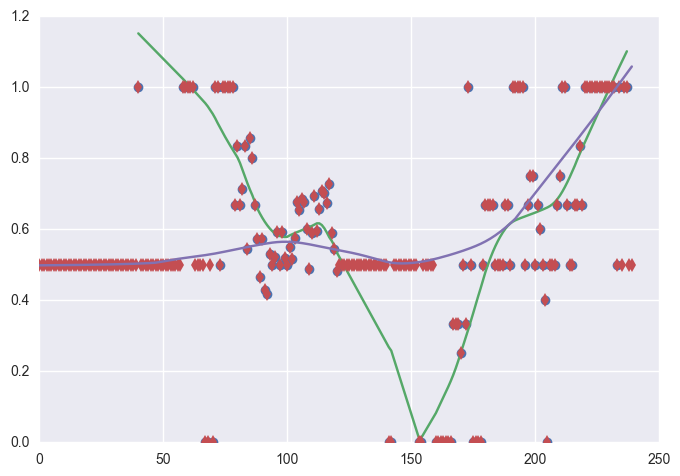

In [59]:
s = we[:,8,5]
plt.figure()
plt.plot(s,'o')
filtered = lowess(s, range(len(s)), is_sorted=True, frac=0.3)
plt.plot(filtered[:,0], filtered[:,1])
t = [0.5 if math.isnan(x) else x for x in s]
plt.plot(t,'d')
filtered = lowess(t, range(len(t)), is_sorted=True, frac=0.4)
plt.plot(filtered[:,0], filtered[:,1])


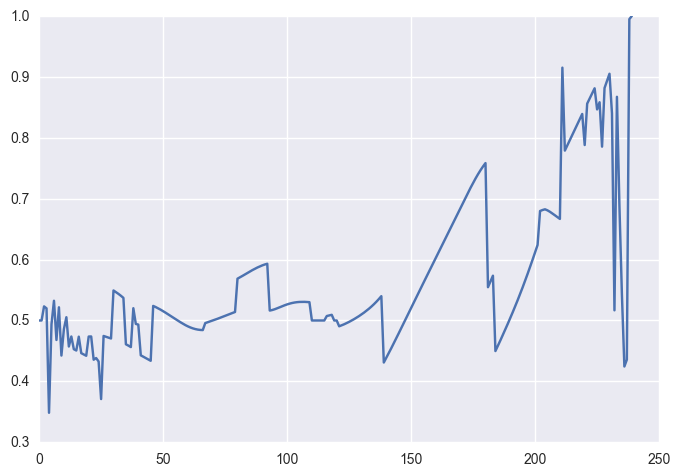

In [60]:
plt.plot(we1)
#plt.plot(range(len(filtered)), filtered[:,1])

In [109]:
m = max(we1)
[i for i,j in enumerate(we1) if j==m]

[41, 80, 94, 100, 101, 102, 103]

In [111]:
we1[40]

0.33333333333333331

In [113]:
dfm[dfm["over"]==7]

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
285,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1,Mumbai Indians,Rising Pune Supergiant,7,1,RG Sharma,JC Buttler,Imran Tahir,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
286,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1,Mumbai Indians,Rising Pune Supergiant,7,2,RG Sharma,JC Buttler,Imran Tahir,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
287,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1,Mumbai Indians,Rising Pune Supergiant,7,3,RG Sharma,JC Buttler,Imran Tahir,0,0,0,0,0,0,0,0,0,RG Sharma,bowled,NaN
288,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1,Mumbai Indians,Rising Pune Supergiant,7,4,N Rana,JC Buttler,Imran Tahir,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
289,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1,Mumbai Indians,Rising Pune Supergiant,7,5,JC Buttler,N Rana,Imran Tahir,0,0,0,0,0,0,0,0,0,JC Buttler,lbw,NaN
290,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,1,Mumbai Indians,Rising Pune Supergiant,7,6,AT Rayudu,N Rana,Imran Tahir,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
410,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,Rising Pune Supergiant,Mumbai Indians,7,1,AM Rahane,SPD Smith,HH Pandya,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
411,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,Rising Pune Supergiant,Mumbai Indians,7,2,SPD Smith,AM Rahane,HH Pandya,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
412,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,Rising Pune Supergiant,Mumbai Indians,7,3,SPD Smith,AM Rahane,HH Pandya,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
413,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,Rising Pune Supergiant,Mumbai Indians,7,4,AM Rahane,SPD Smith,HH Pandya,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN
